In [ ]:
!pip install -U layoutparser


In [ ]:
!pip install layoutparser[ocr]

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2'

  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.4) to /tmp/pip-install-zhk4ox5v/detectron2_b88a90473c3b4d37abae29dccffdf050
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-install-zhk4ox5v/detectron2_b88a90473c3b4d37abae29dccffdf050
  Running command git checkout -q 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
  Resolved https://github.com/facebookresearch/detectron2.git to commit 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
  Preparing metadata (setup.py) ... done


In [ ]:
!git clone https://github.com/Layout-Parser/layout-parser.git
%cd layout-parser/

Cloning into 'layout-parser'...
remote: Enumerating objects: 1357, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 1357 (delta 341), reused 272 (delta 264), pack-reused 957
Receiving objects: 100% (1357/1357), 62.86 MiB | 28.95 MiB/s, done.
Resolving deltas: 100% (739/739), done.
/content/layout-parser/layout-parser


In [ ]:
!pip install pycocotools

In [ ]:
def load_coco_annotations(annotations, coco=None):
    """
    Args:
        annotations (List):
            a list of coco annotaions for the current image
        coco (`optional`, defaults to `False`):
            COCO annotation object instance. If set, this function will
            convert the loaded annotation category ids to category names
            set in COCO.categories
    """
    layout = lp.Layout()

    for ele in annotations:
        x, y, w, h = ele['bbox']

        layout.append(
            lp.TextBlock(
                block = lp.Rectangle(x, y, w+x, h+y),
                type  = ele['category_id'] if coco is None else coco.cats[ele['category_id']]['name'],
                id = ele['id']
            )
        )
    return layout

In [ ]:
import pandas as pd
import numpy as np
import cv2
import random
import json
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


from pycocotools.coco import COCO
import layoutparser as lp

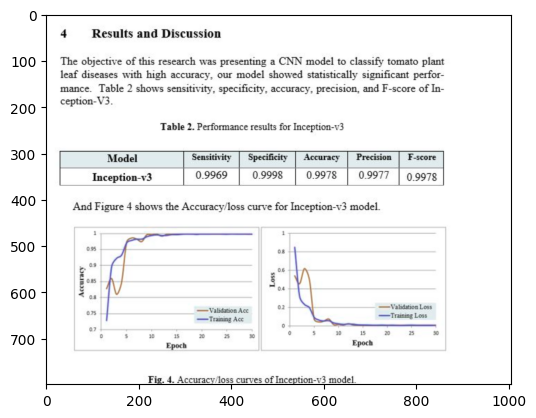

In [ ]:
imgdir="/content/drive/MyDrive/train/train"
image = cv2.imread('/content/drive/MyDrive/train/image.png')
plt.imshow(image)

In [ ]:
f = open('/content/drive/MyDrive/train/train/samples.json',)
thing_classes  = []
category_name_to_id = {}
data_annotations=[]
data = json.load(f)
#----Images----
data_images=data['images']
#---annotations-
for i in data['annotations']:
    annot_obj ={"id": i['id'],"image_id": i['image_id'],"category_id":i['category_id'],
          "x_min":i['bbox'][0], #left
          "y_min":i['bbox'][1], #top
          "x_max":i['bbox'][0]+i['bbox'][2], #left+width
          "y_max":i['bbox'][1]+i['bbox'][3] #top+hieght
         }
    data_annotations.append(annot_obj)
for i in data['categories']:
    thing_classes.append(i['name'])
    category_name_to_id[i['name']]=i['id']
f.close()
print("thing_classes=",thing_classes)
print("category_name_to_id=",category_name_to_id)

thing_classes= ['text', 'title', 'list', 'table', 'figure']
category_name_to_id= {'text': 1, 'title': 2, 'list': 3, 'table': 4, 'figure': 5}


In [ ]:
train_meta = pd.DataFrame(data_images)
train_meta = train_meta[['id', 'file_name', 'width', 'height']]
train_meta = train_meta.rename(columns={"id":"image_id"})
print("train_meta size=",len(train_meta))
train_meta.head(3)

train_meta size= 20


,image_id,file_name,width,height
0,348952,PMC5491943_00004.jpg,596,794
1,384435,PMC5302692_00002.jpg,612,792
2,353156,PMC3863500_00003.jpg,601,792


In [ ]:
train_df = pd.DataFrame(data_annotations)
print("train_df size=",len(train_df))
train_df.head(3)

train_df size= 193


,id,image_id,category_id,x_min,y_min,x_max,y_max
0,3377124,346767,1,37.59,360.34,288.66,401.70
1,3377125,346767,1,37.59,433.64,288.66,454.02
2,3377126,346767,1,306.60,381.37,557.66,422.61


In [ ]:
COCO_ANNO_PATH = '/content/drive/MyDrive/train/train/samples.json'
COCO_IMG_PATH  = '/content/drive/MyDrive/train/train'

coco = COCO(COCO_ANNO_PATH)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


<ipython-input-21-7fca18386350>:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  for image_id in random.sample(coco.imgs.keys(), 1):


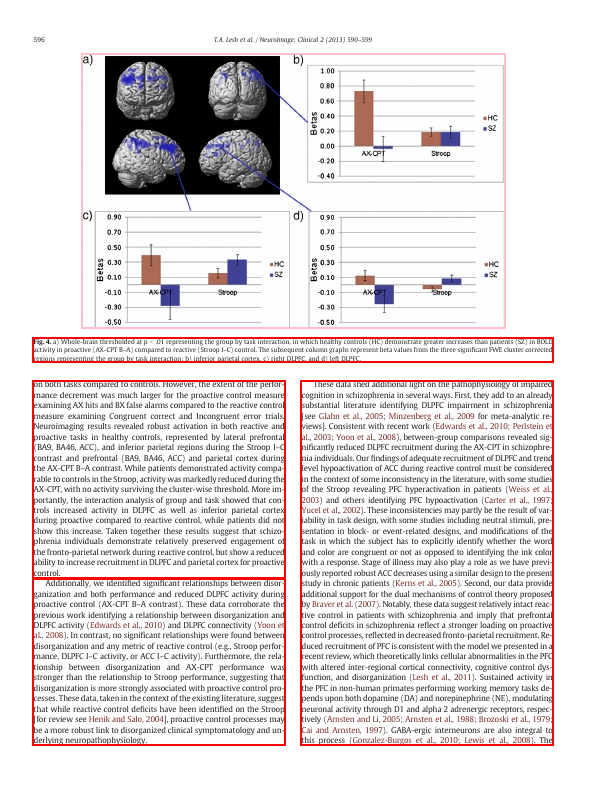

In [ ]:
color_map = {
    'text':   'red',
    'title':  'blue',
    'list':   'green',
    'table':  'yellow',
    'figure': 'pink',
}W


for image_id in random.sample(coco.imgs.keys(), 1):
    image_info = coco.imgs[image_id]
    annotations = coco.loadAnns(coco.getAnnIds([image_id]))

    image = cv2.imread(f'{COCO_IMG_PATH}/{image_info["file_name"]}')
    layout = load_coco_annotations(annotations, coco)

    viz = lp.draw_box(image, layout, color_map=color_map)
    display(viz) # show the results


In [ ]:
model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                 label_map={0: "text", 1: "title", 2: "list", 3:"table", 4:"figure"})

config.yml?dl=1: 8.19kB [00:00, 8.31kB/s]
model_final.pth?dl=1: 330MB [00:05, 57.8MB/s]                          


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


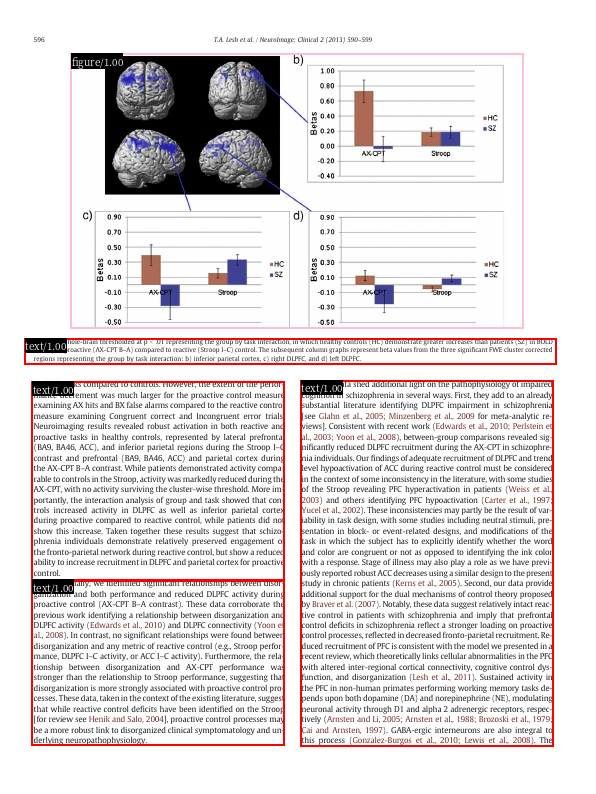

In [ ]:
layout_predicted = model.detect(image)
lp.draw_box(image,
              [b.set(id=f'{b.type}/{b.score:.2f}') for b in layout_predicted],
              color_map=color_map,
              show_element_id=True, id_font_size=10,
              id_text_background_color='black',
              id_text_color='white')

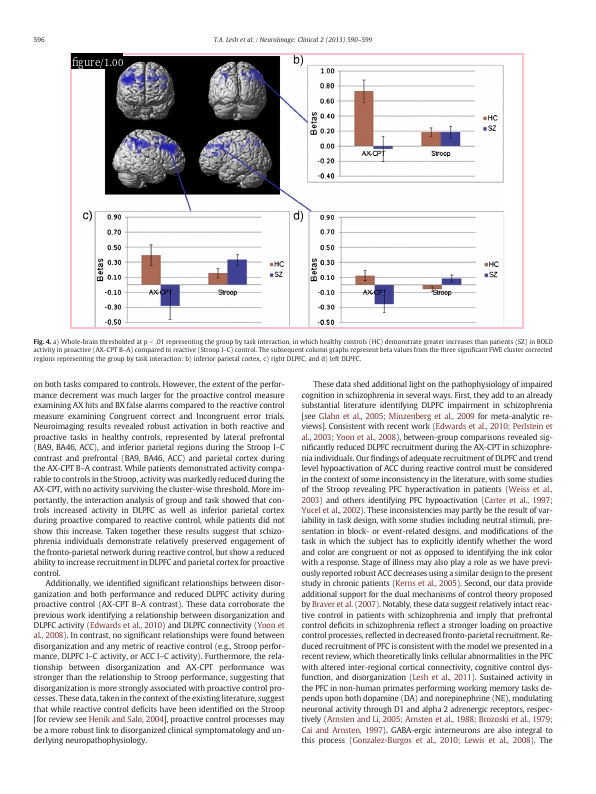

In [ ]:
text_blocks = lp.Layout([b for b in layout_predicted if b.type=="figure"])

lp.draw_box(image,
              [b.set(id=f'{b.type}/{b.score:.2f}') for b in text_blocks ],
              color_map=color_map,
              show_element_id=True, id_font_size=10,
              id_text_background_color='black',
              id_text_color='white')